# Autoencoder

Primero quiero ver simplemente el funcionamiento de un autoencoder.

## Preparacion del entorno

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
# https://www.cs.toronto.edu/~kriz/cifar.html
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='latin')
    return dict

Extraemos los datos del fichero.

In [3]:
batch1 = unpickle("Input\cifar-10-batches-py\data_batch_1")
batch2 = unpickle("Input\cifar-10-batches-py\data_batch_2")
batch3 = unpickle("Input\cifar-10-batches-py\data_batch_3")
batch4 = unpickle("Input\cifar-10-batches-py\data_batch_4")
batch5 = unpickle("Input\cifar-10-batches-py\data_batch_5")

En cifar10 los datos estan almacenados en un diccionario que contiene el nombre del lote, las etiquetas para clasificacion, los datos (imagenes) y los nombres de fichero correspondientes.

In [4]:
print(batch1.keys())
for i in batch1:
    print(i, type(batch1[i]))

dict_keys(['batch_label', 'labels', 'data', 'filenames'])
batch_label <class 'str'>
labels <class 'list'>
data <class 'numpy.ndarray'>
filenames <class 'list'>


Las imagenes vienen en el modo ``channelsfirst``, en este modo, tenemos 3 matrices de la dimension de la imagen, una para cada canal. Muchas de las funciones admiten por defecto el modo ``chanelslast`` en el que tenemos una matriz de la dimension de la imagen y cada posicion tiene un vector con los codigos de color de cada punto.

Por simplicidad, como paso de preprocesamiento, voy a transformar las imagenes de ``channelsfirst`` a ``channelslast``.

In [5]:
# https://www.binarystudy.com/2021/09/how-to-load-preprocess-visualize-CIFAR-10-and-CIFAR-100.html
imagen = batch1["data"][0]
imagen = imagen.reshape(3,32,32)
imagen=imagen.transpose(1,2,0)
print(imagen.shape)

(32, 32, 3)


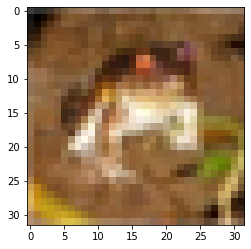

In [6]:
import matplotlib.pyplot as plt
plt.imshow(imagen)

## Preparacion de los datos

Transformo todas las imagenes del lote de ``channelsfirst`` a ``channelslast``.

In [7]:
print(batch1["data"].shape)
X_train = batch1["data"].reshape(10000, 3, 32, 32)
X_train = np.concatenate((X_train, batch2["data"].reshape(10000, 3, 32, 32)))
X_train = np.concatenate((X_train, batch3["data"].reshape(10000, 3, 32, 32)))
X_train = np.concatenate((X_train, batch4["data"].reshape(10000, 3, 32, 32)))
X_train = np.concatenate((X_train, batch5["data"].reshape(10000, 3, 32, 32)))
X_train = X_train.transpose(0,2,3,1)
X_train=X_train/255

(10000, 3072)


(50000, 32, 32, 3)


<Figure size 432x288 with 0 Axes>

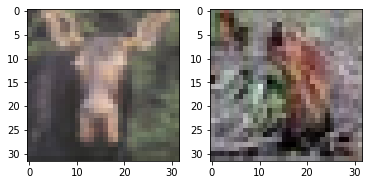

In [8]:
print(X_train.shape)
plt.figure()
f, arrx = plt.subplots(1,2)
arrx[0].imshow(X_train[np.random.randint(0,X_train.shape[0])])
arrx[1].imshow(X_train[np.random.randint(0,X_train.shape[0])])

## Arquitectura del ``Autoencoder``

El ``encoder`` va a ser un modelo basado en ``transfer learning``, vamos a tomar la red de ``mobilenet``, entranada para imagenes de ``imagenet`` sin las capa de clasificacion final, con una entrada de tamaño _img\_shape_ y en el output colocamos la 'representacion latente' una codificacion de la imagen que nos permitiría reconstruirla con un ``decoder``.

In [9]:
# https://www.tensorflow.org/api_docs/python/tf/keras/applications/mobilenet/preprocess_input
# https://keras.io/guides/transfer_learning/
def build_encoder(dim_latente, img_shape):
    inputs = keras.Input(shape=img_shape)
    x=tf.cast(inputs, tf.float32)
    #x=keras.applications.mobilenet.preprocess_input(x)  #dataformat por defecto es chanel last
    core = keras.applications.MobileNet(input_shape=(img_shape), weights="imagenet", include_top=False)
    core.trainable = False
    model = core(x, training=False)
    model = keras.layers.GlobalAveragePooling2D()(model)
    repr_latente = keras.layers.Dense(dim_latente)(model)
    return keras.Model(inputs, repr_latente)


Para el ``decoder``, de momento, estoy tomado prestada una arquitectura de un ejemplo de **mrquincle** en github de un ``decoder`` para imagenes de ``MNIST``.

In [10]:
# https://github.com/mrquincle/keras-adversarial-autoencoders/blob/master/Keras%20Adversarial%20Autoencoder%20MNIST.ipynb
def build_decoder(latent_dim, img_shape):
    model = keras.Sequential()
    model.add(keras.layers.Dense(512, input_dim=latent_dim))
    model.add(keras.layers.LeakyReLU(alpha=0.2))
    model.add(keras.layers.Dense(512))
    model.add(keras.layers.LeakyReLU(alpha=0.2))
    model.add(keras.layers.Dense(np.prod(img_shape), activation='tanh'))
    model.add(keras.layers.Reshape(img_shape))
    z = keras.layers.Input(shape=(latent_dim,))
    img = model(z)
    return keras.Model(z, img)

``Decoder`` alternativo:

In [11]:
def build_myDecoder(dim_latente, img_shape):
    model=keras.Sequential()
    model.add(keras.layers.Dense(256, input_dim=dim_latente))
    model.add(keras.layers.LeakyReLU(alpha=0.2))
    model.add(keras.layers.Dense(512))
    model.add(keras.layers.LeakyReLU(alpha=0.2))
    model.add(keras.layers.Dense(768))
    model.add(keras.layers.LeakyReLU(alpha=0.2))
    model.add(keras.layers.Dense(np.prod(img_shape), activation=keras.activations.tanh))
    model.add(keras.layers.Reshape(img_shape))
    z = keras.layers.Input(shape=(dim_latente))
    img =  model(z)
    return keras.Model(z,img)

Construimos la red

In [12]:
img_shape = X_train[0].shape
dim_latente = 20
optimizer = keras.optimizers.Adam(0.0002, 0.5)

encoder = build_encoder(dim_latente, img_shape)
decoder = build_myDecoder(dim_latente, img_shape)
img = keras.layers.Input(img_shape)

encoder_rep = encoder(img)
autoencoder_out = decoder(encoder_rep)

autoencoder = keras.Model(img, autoencoder_out)
autoencoder.compile(loss='mse', optimizer=optimizer, metrics=["accuracy"])

In [13]:
encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 tf.cast (TFOpLambda)        (None, 32, 32, 3)         0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 1, 1, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 20)                20500     
                                                                 
Total params: 3,249,364
Trainable params: 20,500
Non-trainabl

In [14]:
decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 20)]              0         
                                                                 
 sequential (Sequential)     (None, 32, 32, 3)         2893312   
                                                                 
Total params: 2,893,312
Trainable params: 2,893,312
Non-trainable params: 0
_________________________________________________________________


In [15]:
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 model (Functional)          (None, 20)                3249364   
                                                                 
 model_1 (Functional)        (None, 32, 32, 3)         2893312   
                                                                 
Total params: 6,142,676
Trainable params: 2,913,812
Non-trainable params: 3,228,864
_________________________________________________________________


## Entrenamiento

Imagenes para muestreo visual

In [16]:
def sample_imgs(dataset, model, epoch, sample_size=5, save_imgs=True):
    # Tomamos sample_size imagenes de muestra
    ids = np.random.randint(0,dataset.shape[0], sample_size)
    sample=dataset[ids]
    # Intentamos regenerar las imagenes
    gen_img = model.predict(sample)
    # Guardamos una grafica con la muestra (arriba) y las imagenes generadas (abajo)
    f, axxs = plt.subplots(2,sample_size)
    for j in range(sample_size):
        axxs[0,j].imshow(sample[j])
        axxs[1,j].imshow(gen_img[j])
    if save_imgs:
        f.savefig("autoencoder-EncoderNotTrainable/output/autoencoderCIFAR10_e%d.png" % (epoch))
        plt.close()
    

In [17]:
sample_from = unpickle("Input\cifar-10-batches-py\\test_batch")
sample_from = sample_from["data"]
sample_from.shape

(10000, 3072)

In [18]:
sample_from = sample_from.reshape(10000,3,32,32)
sample_from = sample_from.transpose(0,2,3,1)
sample_from = sample_from/255


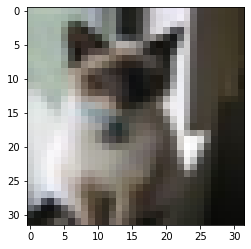

In [19]:
plt.imshow(sample_from[np.random.randint(0,sample_from.shape[0])])

Entrenamiento

In [20]:
# https://github.com/mrquincle/keras-adversarial-autoencoders/blob/master/Keras%20Adversarial%20Autoencoder%20MNIST.ipynb
epochs=10000
batch_size=1000
sample_interval=500

for epoch in range(epochs+1):
    # lote de imagenes
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs = X_train[idx]

    # entrenamos al autoencoder
    loss = autoencoder.train_on_batch(imgs,imgs)
    
    # monitorizamos el progreso
    if epoch % 10==0:
        print("Epoch: %d loss = %f, acc = %.2f%%" % (epoch, loss[0], 100*loss[1]))
    # Hacemos una muestra visual
    if epoch % sample_interval==0:
        sample_imgs(sample_from, autoencoder, epoch)


Epoch: 0 loss = 0.289908, acc = 33.77%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 10 loss = 0.239253, acc = 33.98%
Epoch: 20 loss = 0.085574, acc = 35.05%
Epoch: 30 loss = 0.076358, acc = 43.97%
Epoch: 40 loss = 0.077822, acc = 44.41%
Epoch: 50 loss = 0.075886, acc = 44.80%
Epoch: 60 loss = 0.075807, acc = 45.40%
Epoch: 70 loss = 0.073747, acc = 45.65%
Epoch: 80 loss = 0.072459, acc = 44.37%
Epoch: 90 loss = 0.071762, acc = 44.00%
Epoch: 100 loss = 0.067395, acc = 44.50%
Epoch: 110 loss = 0.066099, acc = 45.19%
Epoch: 120 loss = 0.065045, acc = 45.11%
Epoch: 130 loss = 0.063540, acc = 44.68%
Epoch: 140 loss = 0.062621, acc = 44.84%
Epoch: 150 loss = 0.060397, acc = 44.81%
Epoch: 160 loss = 0.062304, acc = 46.20%
Epoch: 170 loss = 0.061598, acc = 43.62%
Epoch: 180 loss = 0.062961, acc = 44.78%
Epoch: 190 loss = 0.060275, acc = 47.16%
Epoch: 200 loss = 0.060455, acc = 45.19%
Epoch: 210 loss = 0.062517, acc = 44.80%
Epoch: 220 loss = 0.061863, acc = 45.59%
Epoch: 230 loss = 0.059578, acc = 45.66%
Epoch: 240 loss = 0.062513, acc = 44.56%
Epoch: 250 loss = 0.06080

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 9000 loss = 0.060976, acc = 46.59%
Epoch: 9010 loss = 0.060588, acc = 46.60%
Epoch: 9020 loss = 0.058681, acc = 46.77%
Epoch: 9030 loss = 0.060777, acc = 47.09%
Epoch: 9040 loss = 0.060416, acc = 45.99%
Epoch: 9050 loss = 0.059210, acc = 47.08%
Epoch: 9060 loss = 0.060534, acc = 48.96%
Epoch: 9070 loss = 0.059498, acc = 46.69%
Epoch: 9080 loss = 0.059413, acc = 46.13%
Epoch: 9090 loss = 0.059504, acc = 47.36%
Epoch: 9100 loss = 0.059992, acc = 47.04%
Epoch: 9110 loss = 0.059204, acc = 48.88%
Epoch: 9120 loss = 0.058629, acc = 47.92%
Epoch: 9130 loss = 0.061509, acc = 48.10%
Epoch: 9140 loss = 0.060466, acc = 48.13%
Epoch: 9150 loss = 0.058399, acc = 46.59%
Epoch: 9160 loss = 0.058404, acc = 48.18%
Epoch: 9170 loss = 0.060552, acc = 47.55%
Epoch: 9180 loss = 0.058950, acc = 46.97%
Epoch: 9190 loss = 0.061496, acc = 46.83%
Epoch: 9200 loss = 0.058158, acc = 48.13%
Epoch: 9210 loss = 0.057946, acc = 47.43%
Epoch: 9220 loss = 0.060599, acc = 47.22%
Epoch: 9230 loss = 0.058382, acc =

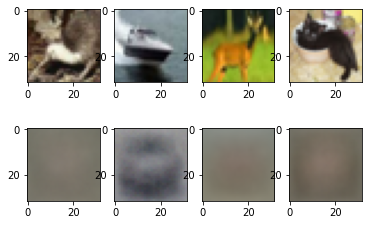

In [21]:
sample_imgs(sample_from, autoencoder, 0, 4, False)


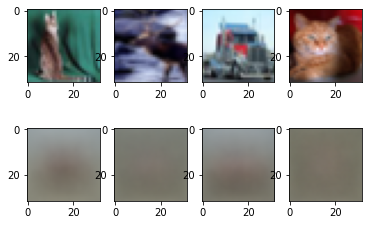

In [22]:
sample_imgs(X_train, autoencoder, 0, 4, False)

In [23]:
import os.path

savefile = "autoencoder-ENT/autoencoder.h5"

if not os.path.isfile(savefile):
    autoencoder.save(savefile)
else:
    print("Ya hay un modelo guardado en "+savefile)

In [24]:
#autoencoder.load_weights("autoencoder/autoencoder.h5")